In [34]:
%pip install POT

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy import optimize

In [36]:
# Parameters and Initialization

rho_num_dim_pts = 40  # number of points per dimension
n_agents = 36         # number of agents
use_rand = True
use_center = False
use_grid = False

lambda_param = 5     # Weight for transport cost
sigma = 0.2           # Kernel width for the negative exponential kernel

n_iter = 500          # Maximum number of iterations for optimizer
reg = 0.01            # Regularization for Sinkhorn transport
np.random.seed(42)

In [37]:
# Discretized measure ρ (grid over [0, 1]^2)

rho_x = np.linspace(0, 1, rho_num_dim_pts)
rho_y = np.linspace(0, 1, rho_num_dim_pts)
rho_X, rho_Y = np.meshgrid(rho_x, rho_y)
rho_pts = np.column_stack([rho_X.ravel(), rho_Y.ravel()])
rho_mass = np.full(rho_pts.shape[0], 1 / rho_pts.shape[0])

In [38]:
# Measure μ (agents) Initialization

# Mass measure μ
mu_mass = np.full(n_agents, 1 / n_agents)

# Initialize at random points
X_init_rand = np.random.rand(n_agents, 2)

# Initialize all agents at the center point (0.5, 0.5) + noise
#X_init_center = np.full((n_agents, 2), 0.5) + np.random.randn(n_agents, 2)*0.05
X_init_center = np.full((n_agents, 2), 0.5)

ag_per_dim = int(np.ceil(np.sqrt(n_agents)))

# initialize all agents in a square
corners = np.array([
    [0.3, 0.3],  # lower‐left
    [0.3, 0.7],  # upper‐left
    [0.7, 0.3],  # lower‐right
    [0.7, 0.7],  # upper‐right
])

# 2) replicate each corner
X_init_square = np.repeat(corners, int(np.ceil(n_agents/4)), axis=0)



# Create evenly spaced grid points in [0, 1]
# The grid naturally has a center at 0.5.
x_vals = np.linspace(0, 1, ag_per_dim)
y_vals = np.linspace(0, 1, ag_per_dim)
# Create meshgrid
xx, yy = np.meshgrid(x_vals, y_vals)

# Stack the grid points and select only n_agents positions
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
X_init_grid = grid_points[:n_agents]

if use_rand:
    X_init = X_init_rand
elif use_center:
    X_init = X_init_center
elif use_grid:
    X_init = X_init_grid
else:
    X_init = X_init_square

In [39]:
# Define Functions: Cost, Kernel, and Energy

def neg_exp_k(r, sigma):
    return -np.exp(-r**2 / (2 * sigma**2))

def neg_inv_quad(r, sigma):
    return -(1/(1+(r**2)/(sigma**2)))

def pop_k(X, kernel):
    total = 0.0
    n = len(X)
    for i in range(n):
        for j in range(i):
            d = np.linalg.norm(X[i] - X[j])
            total += kernel(d)
    return total

In [40]:
# Define a wrapper for the social interaction energy using our kernel with fixed sigma.

pop_kernel = lambda pts: pop_k(pts, lambda r: neg_inv_quad(r, sigma))

def energy(rho_pts, rho_mass, mu_pts, mu_mass, lambda_param, pop_kernel, reg):
    n_ag = len(mu_pts)
    social_E = pop_kernel(mu_pts)
    C = ot.dist(rho_pts, mu_pts, metric='euclidean') ** 2
    transport_E = ot.sinkhorn2(rho_mass, mu_mass, C, reg)
    return (1/(2*(n_ag**2)))*social_E + (lambda_param/2)*transport_E

# Objective function for optimization: maps a flattened vector to the energy value.
def objective(flat_X):
    X = flat_X.reshape(n_agents, 2)
    return energy(rho_pts, rho_mass, X, mu_mass, lambda_param, pop_kernel, reg)

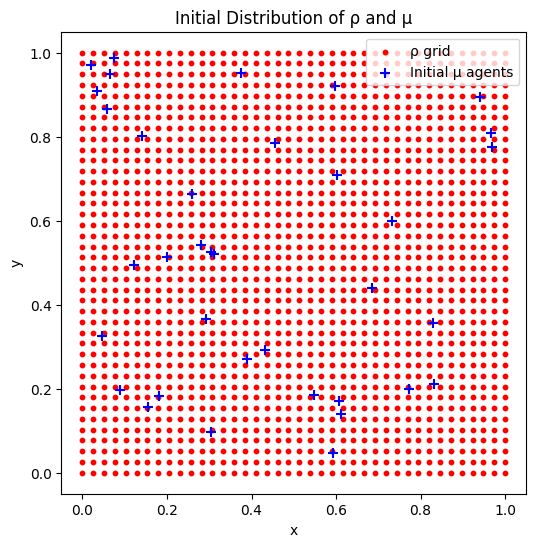

In [42]:
# Plot the Initial Distribution of ρ and μ

plt.figure(figsize=(6, 6))
plt.scatter(rho_pts[:, 0], rho_pts[:, 1], s=10, c='red', marker = 'o', label='ρ grid')
plt.scatter(X_init[:, 0], X_init[:, 1], s=50, c='blue', marker = '+', label='Initial μ agents')
plt.legend()
plt.title('Initial Distribution of ρ and μ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [43]:
print("Initial energy:", energy(rho_pts, rho_mass, X_init, mu_mass, lambda_param, pop_kernel, reg))

Initial energy: 0.050328564709796034


In [44]:
# Optimization Setup

# Flatten initial agent positions for the optimizer.
X0 = X_init.ravel()

# Bounds: each coordinate is constrained within [0,1]
bounds = [(0, 1) for _ in range(n_agents * 2)]

# Use L-BFGS-B algorithm for bounded minimization.
result = optimize.minimize(objective, X0, method='L-BFGS-B', bounds=bounds,
                           options={'maxiter': n_iter, 'disp': True})

# Retrieve the optimal positions and reshape to (n_agents x 2)
optimal_X = result.x.reshape(n_agents, 2)

Optimization success: True
Final energy: 0.007287092678066997
Number of iterations: 34


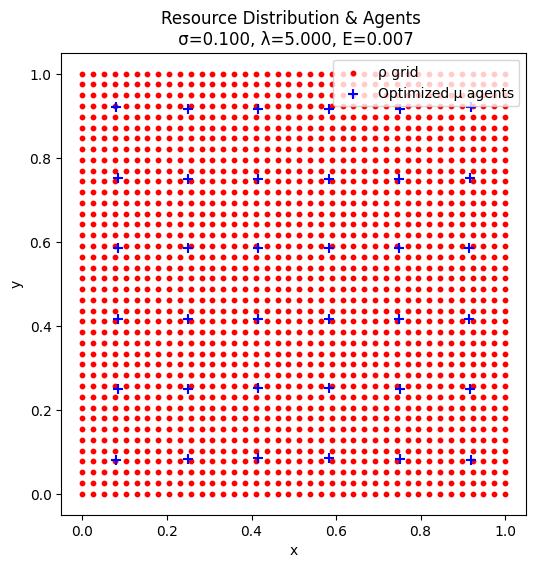

In [45]:
# Output and Final Plot of Optimized Configuration

print("Optimization success:", result.success)
print("Final energy:", result.fun)
print("Number of iterations:", result.nit)

plt.figure(figsize=(6, 6))
plt.scatter(rho_pts[:, 0], rho_pts[:, 1], s=10, c='red', marker = 'o', label='ρ grid')
plt.scatter(optimal_X[:, 0], optimal_X[:, 1], s=50, c='blue', marker = '+', label='Optimized μ agents')
plt.legend()
plt.title(f"Resource Distribution & Agents \n σ={sigma:.3f}, λ={lambda_param:.3f}, E={result.fun:.3f}")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


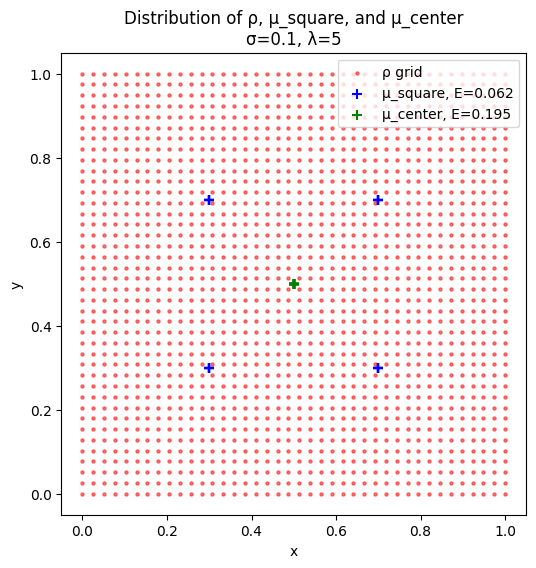

In [41]:
# Plot the Distribution of ρ and μ for square and center examples

E_sq = np.round(energy(rho_pts, rho_mass, X_init_square, mu_mass, lambda_param, pop_kernel, reg),3)
E_cen = np.round(energy(rho_pts, rho_mass, X_init_center, mu_mass, lambda_param, pop_kernel, reg),3)


plt.figure(figsize=(6, 6))
plt.scatter(rho_pts[:, 0], rho_pts[:, 1], s=5, c='red', marker = 'o', alpha = 0.5, label='ρ grid')
plt.scatter(X_init_square[:, 0], X_init_square[:, 1], s=50, c='blue', marker = '+', label=f'μ_square, E={E_sq}')
plt.scatter(X_init_center[:, 0], X_init_center[:, 1], s=50, c='green', marker = '+', label=f'μ_center, E={E_cen}')
plt.legend()
plt.title(f'Distribution of ρ, μ_square, and μ_center\nσ={sigma}, λ={lambda_param}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
